In [1]:
import os
import sys
import matplotlib.pyplot as plt

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'BlackBox_Attack'))

In [2]:
from attack import *

/home/jn/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2025-07-25 12:44:08.183703: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-25 12:44:09.941125: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

from TabNet import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer

In [4]:
data = pd.read_csv('../../../Dataset/PhiUSIIL_Phishing_URL_Dataset.csv')
data.head()

/tmp/ipykernel_1144840/2949735167.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['Label'] = data['Label'].replace({'fraudulent': 0, 'legitimate': 1})


,Online shop URL,Label,Domain length,Top domain length,Presence of prefix 'www',Number of digits,Number of letters,Number of dots (.),Number of hyphens (-),Presence of credit card payment,...,SSL certificate expire date,Issuer organization,SSL certificate issuer organization list item,Indication of young domain,Domain registration date,Presence of TrustPilot reviews,TrustPilot score,Presence of SiteJabber reviews,Presence in the standard Tranco list,Tranco List rank
0,https://www.allaccessorybest.com,0,24,3,1,0,27,2,0,1,...,Oct 11 03:53:36 2023 GMT,Google Trust Services LLC,9,1,2023-05-15 03:35,0,NaN,0,0,-1
1,https://www.b-watches.shop,0,18,4,1,0,20,2,1,0,...,Jun 16 23:59:59 2024 GMT,"Cloudflare, Inc.",1,1,2023-06-18 05:43,0,NaN,0,0,-1
2,https://www.waeschenamen-windrath.de,1,28,2,1,0,30,2,1,1,...,Oct 24 21:53:20 2023 GMT,Let's Encrypt,2,1,Hidden,0,-1.0,0,0,-1
3,https://vendoprint.se,1,13,2,0,0,17,1,0,1,...,Oct 9 15:13:00 2023 GMT,Google Trust Services LLC,9,1,2022-09-20 00:00,0,-1.0,0,0,-1
4,https://www.newbikeland.com,0,19,3,1,0,22,2,0,1,...,Oct 25 08:20:27 2023 GMT,Let's Encrypt,2,1,2023-07-27 09:05,0,NaN,0,0,-1


In [5]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
data.head()

,Label,Domain length,Top domain length,Presence of prefix 'www',Number of digits,Number of letters,Number of dots (.),Number of hyphens (-),Presence of credit card payment,Presence of money back payment,...,Presence of crypto currency,Presence of free contact emails,Presence of logo URL,SSL certificate issuer organization list item,Indication of young domain,Presence of TrustPilot reviews,TrustPilot score,Presence of SiteJabber reviews,Presence in the standard Tranco list,Tranco List rank
0,0,24,3,1,0,27,2,0,1,1,...,0,0,0,9,1,0,NaN,0,0,-1
1,0,18,4,1,0,20,2,1,0,1,...,0,1,0,1,1,0,NaN,0,0,-1
2,1,28,2,1,0,30,2,1,1,0,...,0,1,1,2,1,0,-1.0,0,0,-1
3,1,13,2,0,0,17,1,0,1,0,...,0,1,1,9,1,0,-1.0,0,0,-1
4,0,19,3,1,0,22,2,0,1,1,...,0,0,1,2,1,0,NaN,0,0,-1


In [6]:
def normalize_feature_name(feat_name: str) -> str:
    import re
    # Remove binning patterns like "0.1 < feature <= 3.2", "feature = 1", etc.
    return re.sub(r'([<>]=?|=)\s*[-+]?\d+(\.\d+)?', '', feat_name).strip()

In [8]:
protected_feature = 'IsHTTPS'
protected_feature = normalize_feature_name(protected_feature)

In [9]:
x_train, x_test, y_train, y_test, feature_names, scaler = Data_Handler(
        df=data,
        target_column='Label',
        protected_feature=protected_feature,
        do_scaling=True,
        scale_all_features=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling ALL numerical features as requested (scale_all_features=True).
Features actually being scaled: ['Domain length', 'Top domain length', 'Number  of digits', 'Number  of hyphens (-)', 'Presence of credit card payment', 'Presence of cash on delivery payment', 'Presence of crypto currency', 'Presence of free contact emails', 'Presence of logo URL', 'Presence of SiteJabber reviews', 'Presence in the standard Tranco list', 'Indication of young domain']


In [10]:
numerical_features = ['URLLength', 'DomainLength', 'TLDLegitimateProb', 'LineOfCode', 'LargestLineLength', 'NoOfPopup', 'NoOfiFrame', 'NoOfCSS', 'NoOfEmptyRef']

In [11]:
feature_names = list(x_train.columns[:])
class_names = ['Malicious', 'Benign']
feature_names

['Domain length',
 'Top domain length',
 'Number  of digits',
 'Number  of hyphens (-)',
 'Presence of credit card payment',
 'Presence of cash on delivery payment',
 'Presence of crypto currency',
 'Presence of free contact emails',
 'Presence of logo URL',
 'Presence of SiteJabber reviews',
 'Presence in the standard Tranco list',
 'Indication of young domain']

In [12]:
def get_categorical_feature_indices(all_feature_names: list, numerical_feature_names: list) -> list:
    """
    Identifies categorical feature names and their indices by excluding numerical features
    from the complete list of feature names.

    Args:
        all_feature_names (list): A list containing all feature names in their original order.
        numerical_feature_names (list): A list containing the names of numerical features.

    Returns:
        list: A sorted list of integer indices corresponding to the categorical features.
    """
    # Convert numerical_feature_names to a set for efficient lookup
    numerical_features_set = set(numerical_feature_names)

    categorical_feature_names = []
    categorical_feature_indices = []

    # Iterate through all feature names to identify categorical ones
    for i, feature_name in enumerate(all_feature_names):
        if feature_name not in numerical_features_set:
            categorical_feature_names.append(feature_name)
            categorical_feature_indices.append(i)

    # Sort the indices to ensure consistent order
    categorical_feature_indices.sort()

    return categorical_feature_indices

In [13]:
categorical_features_indices = get_categorical_feature_indices(x_train.columns, numerical_features)
categorical_features = list(x_train.columns[:][categorical_features_indices])
categorical_features

['Number  of digits',
 'Number  of hyphens (-)',
 'Presence of credit card payment',
 'Presence of cash on delivery payment',
 'Presence of crypto currency',
 'Presence of free contact emails',
 'Presence of logo URL',
 'Presence of SiteJabber reviews',
 'Presence in the standard Tranco list',
 'Indication of young domain']

In [14]:
x_train_tensor = torch.tensor(x_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

# For testing data
x_test_tensor = torch.tensor(x_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

batch_size = 2 # Changed to a smaller size for demonstration with small dataset

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Accuracy: 0.9122807017543859
Precision: 0.9123268698060941
Recall: 0.9122807017543859
F-1: 0.9121776879335669


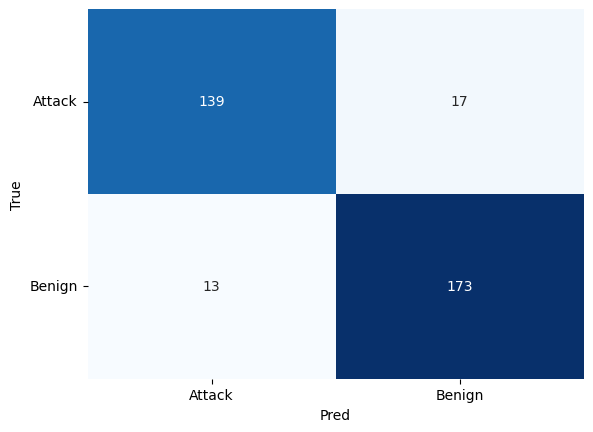

In [15]:
biased_model = base_model_call(
    x_train=x_train,
    y_train=y_train,
    protected_feature=protected_feature,
    keep_protected_feature=True,
    num_epochs=50,
    hidden_sizes=[128, 64],
    dropout_rate=0.3
)
y_pred_biased_model = biased_model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred_biased_model)

In [16]:
attacker = BlackBoxIInterpretationAttack(
    target_model=biased_model.pytorch_model,
    generate_explanation_func=lambda m, x, c: my_tabular_explanation_function(m, x, c, 'integrated_gradients'),
    scaler=scaler, # Pass the fitted scaler
    scaled_feature_names=feature_names, # All feature names were scaled
    all_feature_names=feature_names, # All original feature names
    numerical_feature_names_for_perturbation=numerical_features, # All are perturbable
    categorical_feature_names=categorical_features, # Empty list for Iris
    device='cpu'
)


Features allowed for perturbation: ['Domain length', 'Top domain length']
Categorical features (will not be perturbed): ['Number  of digits', 'Number  of hyphens (-)', 'Presence of credit card payment', 'Presence of cash on delivery payment', 'Presence of crypto currency', 'Presence of free contact emails', 'Presence of logo URL', 'Presence of SiteJabber reviews', 'Presence in the standard Tranco list', 'Indication of young domain']


In [17]:
results, asr = attacker.run_attack(test_dataloader, num_samples_to_attack=50, C=0.1)
print(f"Final Attack Success Rate: {asr:.2%}")


Starting attack...


Collected 100 samples and explanations in 6.94 seconds.
Approximating manifolds with UMAP...


/home/jn/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jn/anaconda3/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Manifolds approximated in 6.65 seconds.
  Attack for sample 1/100 took 124.05s, Success: False
  Attack for sample 2/100 took 83.59s, Success: False
  Attack for sample 3/100 took 123.61s, Success: False
  Attack for sample 4/100 took 280.70s, Success: False
  Attack for sample 5/100 took 57.20s, Success: False
  Attack for sample 6/100 took 43.82s, Success: False
  Attack for sample 7/100 took 57.15s, Success: False
  Attack for sample 8/100 took 109.90s, Success: False
  Attack for sample 9/100 took 228.90s, Success: False
  Attack for sample 10/100 took 43.83s, Success: False
  Attack for sample 11/100 took 69.89s, Success: False
  Attack for sample 12/100 took 57.80s, Success: False
  Attack for sample 13/100 took 227.79s, Success: False
  Attack for sample 14/100 took 162.93s, Success: False
  Attack for sample 15/100 took 57.22s, Success: False
  Attack for sample 16/100 took 176.78s, Success: False
  Attack for sample 17/100 took 56.67s, Success: False
  Attack for sample 18/100


Found 3 successful attacks.

--- Plotting for Successful Attack 1 (Index 0) ---
Plotting for Attack Index 0 WITHOUT target explanation.

Plotting for Stored Successful Attack at Index 0:
Original Class: 0
Adv Class: 0
KL Divergence: 0.0224
Perturbation Norm: 0.0571


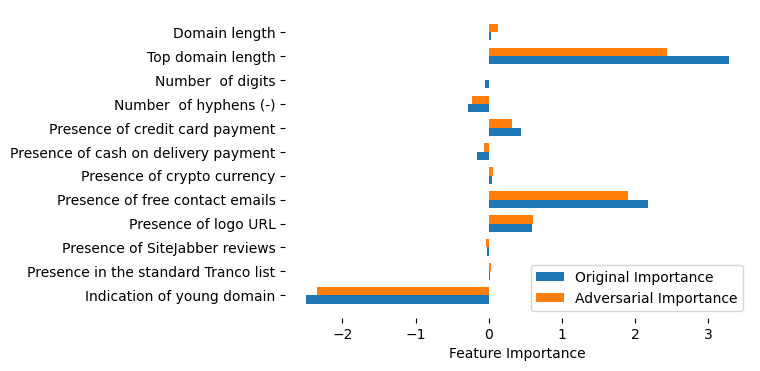

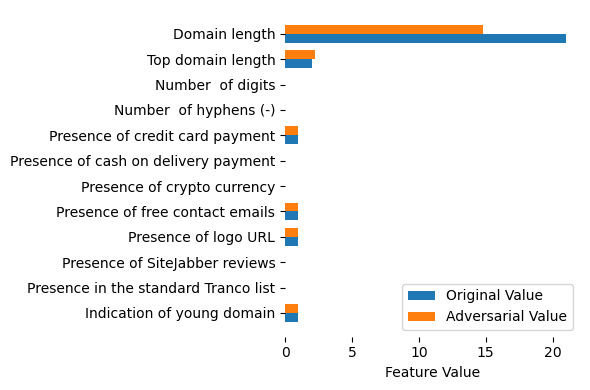

Plotting for Attack Index 0 WITH target explanation.

Plotting for Stored Successful Attack at Index 0:
Original Class: 0
Adv Class: 0
KL Divergence: 0.0224
Perturbation Norm: 0.0571


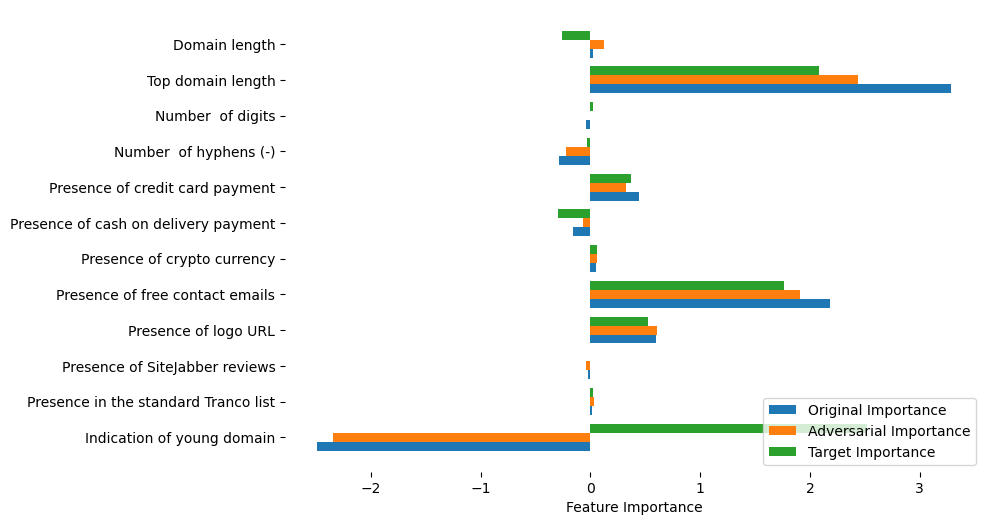

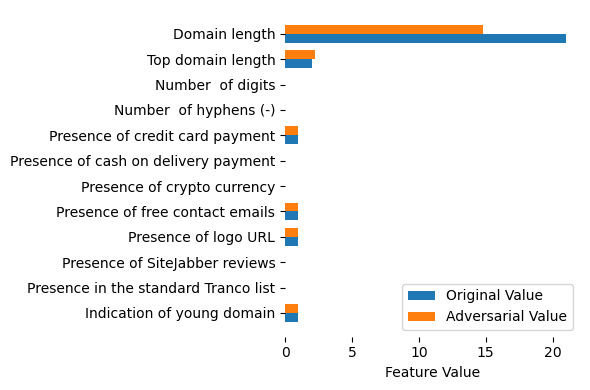


--- Plotting for Successful Attack 2 (Index 1) ---
Plotting for Attack Index 1 WITHOUT target explanation.

Plotting for Stored Successful Attack at Index 1:
Original Class: 0
Adv Class: 0
KL Divergence: 0.0387
Perturbation Norm: 0.0078


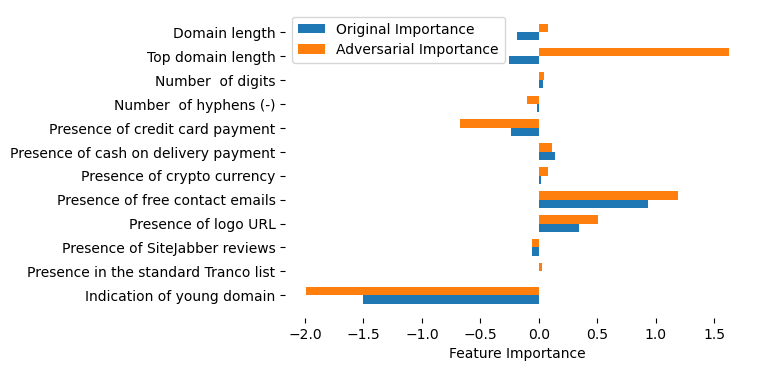

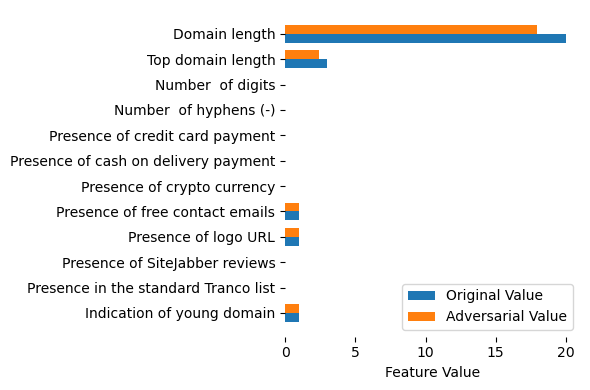

Plotting for Attack Index 1 WITH target explanation.

Plotting for Stored Successful Attack at Index 1:
Original Class: 0
Adv Class: 0
KL Divergence: 0.0387
Perturbation Norm: 0.0078


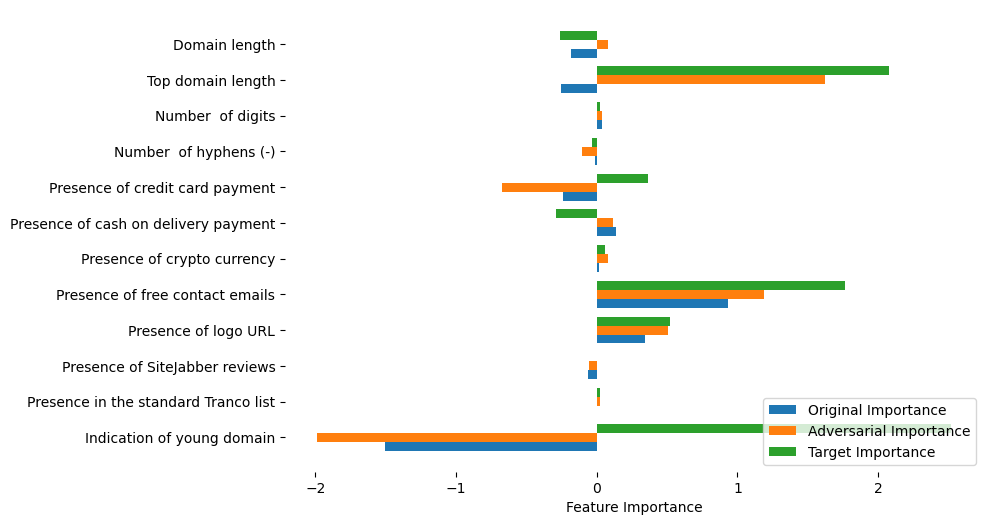

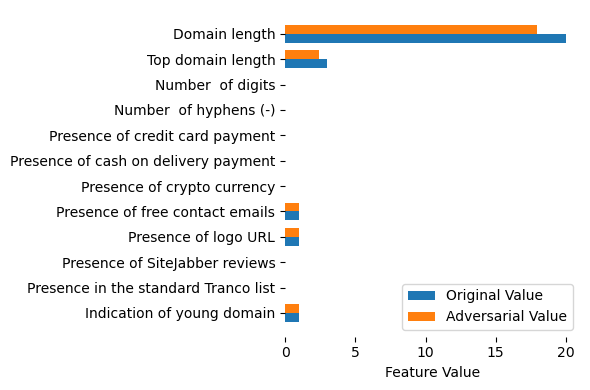


--- Plotting for Successful Attack 3 (Index 2) ---
Plotting for Attack Index 2 WITHOUT target explanation.

Plotting for Stored Successful Attack at Index 2:
Original Class: 0
Adv Class: 0
KL Divergence: 0.0385
Perturbation Norm: 0.0000


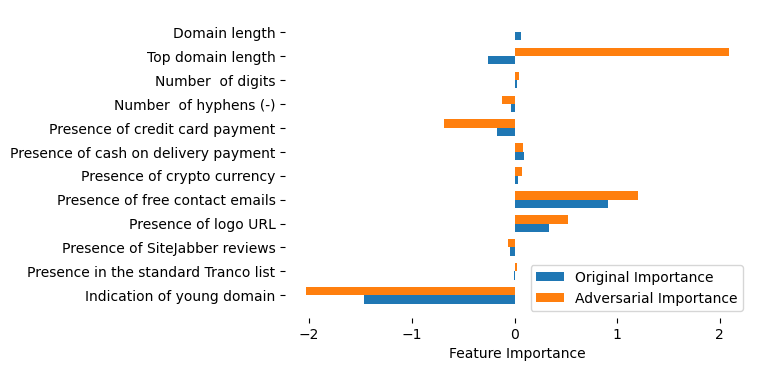

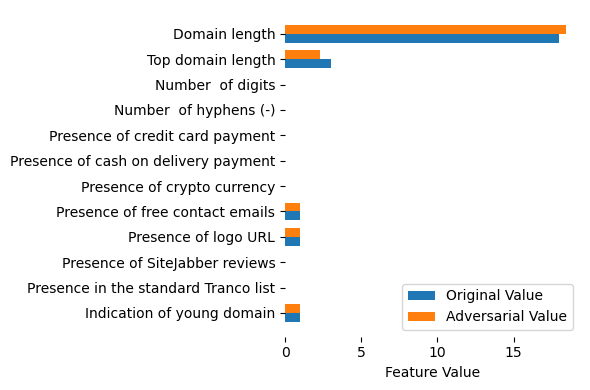

Plotting for Attack Index 2 WITH target explanation.

Plotting for Stored Successful Attack at Index 2:
Original Class: 0
Adv Class: 0
KL Divergence: 0.0385
Perturbation Norm: 0.0000


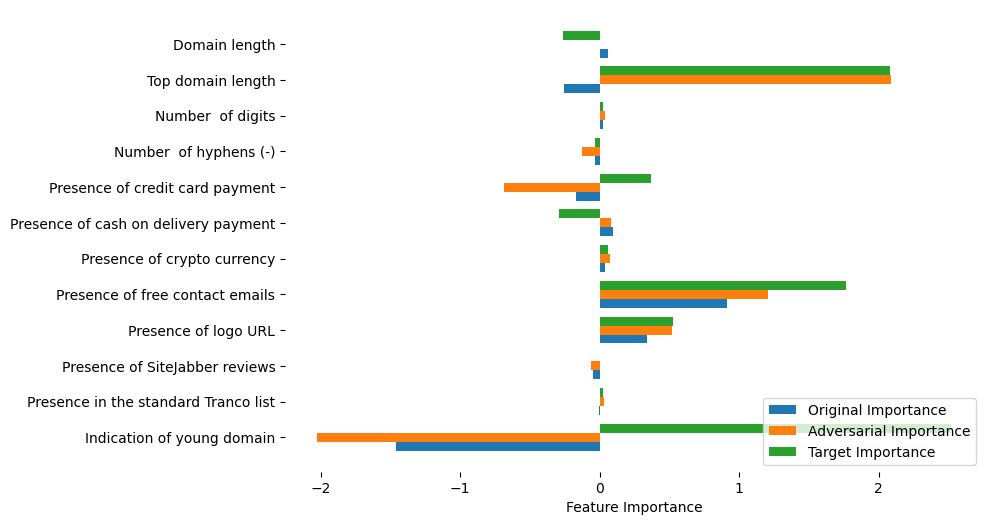

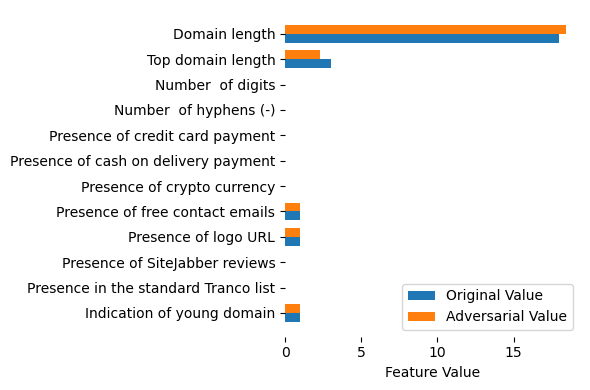

In [18]:
if attacker.attack_results: # Check if any successful attacks were stored
    print(f"\nFound {len(attacker.attack_results)} successful attacks.")

    # Plot each successful attack with and without target explanation
    for i, (original, x_adv, target_exp, result) in enumerate(attacker.attack_results):
        print(f"\n--- Plotting for Successful Attack {i+1} (Index {i}) ---")

        print(f"Plotting for Attack Index {i} WITHOUT target explanation.")
        attacker.plot_attack_result(i, include_target_explanation_plot=False)

        print(f"Plotting for Attack Index {i} WITH target explanation.")
        attacker.plot_attack_result(i, include_target_explanation_plot=True)

else:
    print("\nNo successful attack found to visualize. Try increasing num_samples_to_attack or adjusting C or max_iter.")